# Imports

In [2]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import os
import ast
from PIL import Image


from scipy.ndimage import gaussian_filter


import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.layers import Dense, Flatten
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam

from tensorflow.keras.preprocessing.image import ImageDataGenerator

from concurrent.futures import ThreadPoolExecutor
from tqdm.notebook import tqdm

from tensorflow.keras.preprocessing.image import save_img
from tensorflow.keras.preprocessing.image import load_img
from tensorflow.keras.preprocessing.image import img_to_array
from tensorflow.keras.utils import to_categorical

#from tensorflow.keras.applications.resnet50 import preprocess_input


from tensorflow.keras.layers import Flatten, Dense, Dropout, BatchNormalization
from tensorflow.keras.callbacks import EarlyStopping

from sklearn.model_selection import train_test_split
from concurrent.futures import ThreadPoolExecutor, as_completed

from tensorflow.keras.applications import ResNet50
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint
from keras.regularizers import l2
from sklearn.preprocessing import LabelEncoder



# Access Dataset
- Within the Dataset, patient age and sex is provided with diagnosis for both the left and right eye being given. One hot encoding is used for the ocular conditions, each condition is represented by its own column where for each image a binary value of 1 or 0 is given to indicate the absence of presence of a disease. The labels coloumn includes the actual diagnosis label for the patient with the target column providing a binary vector representation of the conditions aligning with the individual conditions problem. 




In [3]:
df = pd.read_csv('dataset\\full_df.csv')
df.head()

,ID,Patient Age,Patient Sex,Left-Fundus,Right-Fundus,Left-Diagnostic Keywords,Right-Diagnostic Keywords,N,D,G,C,A,H,M,O,filepath,labels,target,filename
0,0,69,Female,0_left.jpg,0_right.jpg,cataract,normal fundus,0,0,0,1,0,0,0,0,../input/ocular-disease-recognition-odir5k/ODI...,['N'],"[1, 0, 0, 0, 0, 0, 0, 0]",0_right.jpg
1,1,57,Male,1_left.jpg,1_right.jpg,normal fundus,normal fundus,1,0,0,0,0,0,0,0,../input/ocular-disease-recognition-odir5k/ODI...,['N'],"[1, 0, 0, 0, 0, 0, 0, 0]",1_right.jpg
2,2,42,Male,2_left.jpg,2_right.jpg,laser spot，moderate non proliferative retinopathy,moderate non proliferative retinopathy,0,1,0,0,0,0,0,1,../input/ocular-disease-recognition-odir5k/ODI...,['D'],"[0, 1, 0, 0, 0, 0, 0, 0]",2_right.jpg
3,4,53,Male,4_left.jpg,4_right.jpg,macular epiretinal membrane,mild nonproliferative retinopathy,0,1,0,0,0,0,0,1,../input/ocular-disease-recognition-odir5k/ODI...,['D'],"[0, 1, 0, 0, 0, 0, 0, 0]",4_right.jpg
4,5,50,Female,5_left.jpg,5_right.jpg,moderate non proliferative retinopathy,moderate non proliferative retinopathy,0,1,0,0,0,0,0,0,../input/ocular-disease-recognition-odir5k/ODI...,['D'],"[0, 1, 0, 0, 0, 0, 0, 0]",5_right.jpg


# Preparation of the dataset

In [4]:
# Since the labels are stored as string representations of lists, we need to convert them back to lists
df['labels_list'] = df['labels'].apply(lambda x: ast.literal_eval(x))

# For simplicity, let's focus on cases where only a single condition is present.
# This means we'll temporarily ignore images labeled with multiple conditions.
single_condition_df = df[df['labels_list'].apply(len) == 1]

# Extract the single label from each list
single_condition_df['single_label'] = single_condition_df['labels_list'].apply(lambda x: x[0])

# Encode the labels
label_encoder = LabelEncoder()
single_condition_df['label_encoded'] = label_encoder.fit_transform(single_condition_df['single_label'])

# Split the dataset into training and test sets
X_train, X_test, y_train, y_test = train_test_split(single_condition_df[['filepath', 'filename']],
                                                    single_condition_df['label_encoded'],
                                                    test_size=0.2, random_state=42)

# Overview of the split
(X_train.shape, X_test.shape), (y_train.shape, y_test.shape)

(((5113, 2), (1279, 2)), ((5113,), (1279,)))

In [5]:
X_train_final, X_val, y_train_final, y_val = train_test_split(X_train, y_train, test_size=0.2, random_state=42)
(X_train_final.shape, X_val.shape), (y_train_final.shape, y_val.shape)

(((4090, 2), (1023, 2)), ((4090,), (1023,)))

In [6]:
single_condition_df.to_csv('dataset\\csv\\single_condition_df.csv', index=False)

# Class Distribution
- Below is shown the distribution of images available for each different ocular condition. This distribution shows a significant imbalance, with "Normal" and "Diabetes" conditions being the most represented, while conditions like "Hypertension" and "Glaucoma" have far fewer images.

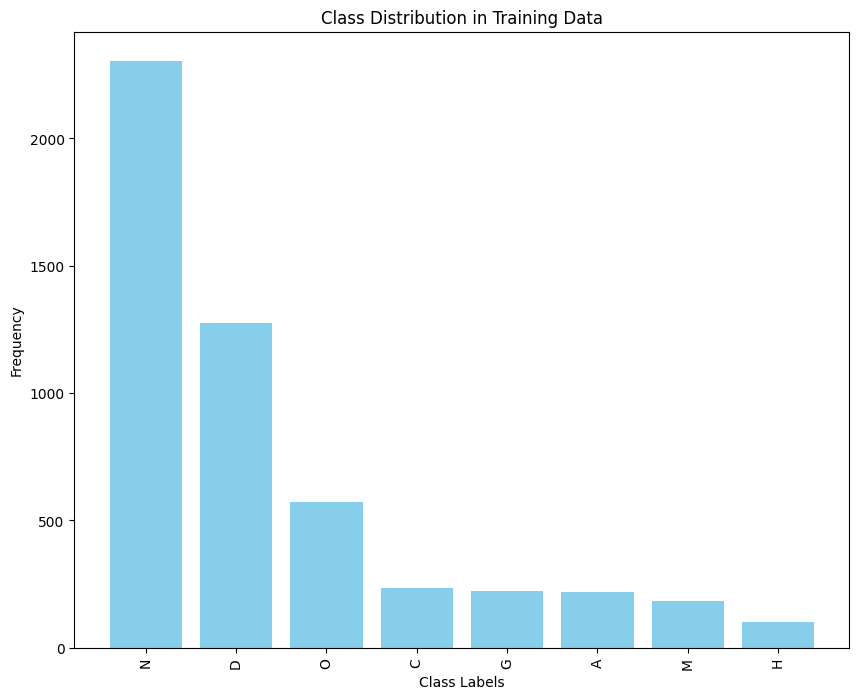

In [7]:
# Check the class distribution in the training set
class_distribution = y_train.value_counts()

# Convert the encoded labels back to their original string labels for better readability
class_labels = label_encoder.inverse_transform(class_distribution.index)

# Plot the class distribution
plt.figure(figsize=(10, 8))
plt.bar(class_labels, class_distribution.values, color='skyblue')
plt.xlabel('Class Labels')
plt.ylabel('Frequency')
plt.title('Class Distribution in Training Data')
plt.xticks(rotation=90)
plt.show()

# Dealing with class imbalance - Data Augmentation 
- Data augmentation involves artificially increasing the size of your dataset by generating new data by resusing exisitng data, useful for underrepresented classes. Examples include rotations, flipping, noise, colour variations. 
- Will increase each minority class size to 2000 images by using the class counts and classes with less than 2000 images will be augmeneted to increase their size to 2000.
- The following minority classes should have their class sizes balanced -  G (Glaucoma), C (Cataract) , A (Age related Macular Degeneration), H (Hypertension), M (Pathological Myopia).

In [8]:
# Setup augmentation only for minority classes
augmentation = ImageDataGenerator(
    rotation_range=20,
    width_shift_range=0.1,
    height_shift_range=0.1,
    shear_range=0.1,
    zoom_range=0.1,
    horizontal_flip=True,
    fill_mode='nearest'
)

# No augmentation for majority classes
no_augmentation = ImageDataGenerator()

In [9]:
y_train_final.head()

5535    6
5760    2
1273    2
3432    6
3510    7
Name: label_encoded, dtype: int32

In [11]:
# Threshold for distinguishing minority classes
threshold = 1500

# Calculate class distribution
class_counts = y_train_final.value_counts()

# Identify minority and majority classes based on the threshold
minority_classes = class_counts[class_counts < threshold].index.tolist()
majority_classes = class_counts[class_counts >= threshold].index.tolist()

# Filter indices for minority and majority classes
minority_indices = y_train_final[y_train_final.isin(minority_classes)].index
majority_indices = y_train_final[y_train_final.isin(majority_classes)].index

# Select the rows for minority and majority classes from X_train_final
minority_data = X_train_final.loc[minority_indices]
majority_data = X_train_final.loc[majority_indices]

# Add the 'label_encoded' column to minority and majority data
minority_data['label_encoded'] = y_train_final.loc[minority_indices].values
majority_data['label_encoded'] = y_train_final.loc[majority_indices].values

# Check if the label_encoded column has been added successfully
print(minority_data.head())
print(majority_data.head())


                                               filepath        filename  \
5760  ../input/ocular-disease-recognition-odir5k/ODI...   3960_left.jpg   
1273  ../input/ocular-disease-recognition-odir5k/ODI...  1657_right.jpg   
3510  ../input/ocular-disease-recognition-odir5k/ODI...    364_left.jpg   
887   ../input/ocular-disease-recognition-odir5k/ODI...  1048_right.jpg   
2745  ../input/ocular-disease-recognition-odir5k/ODI...  4171_right.jpg   

      label_encoded  
5760              2  
1273              2  
3510              7  
887               4  
2745              2  
                                               filepath        filename  \
5535  ../input/ocular-disease-recognition-odir5k/ODI...   3231_left.jpg   
3432  ../input/ocular-disease-recognition-odir5k/ODI...    277_left.jpg   
5335  ../input/ocular-disease-recognition-odir5k/ODI...   3014_left.jpg   
5391  ../input/ocular-disease-recognition-odir5k/ODI...   3080_left.jpg   
858   ../input/ocular-disease-recognition-

In [12]:
minority_generator = augmentation.flow_from_dataframe(
    dataframe=minority_data,
    directory='dataset/preprocessed_images', # Update this as per your directory structure
    x_col='filename',
    y_col='label_encoded',
    target_size=(256, 256),
    color_mode='rgb',
    class_mode='raw',
    batch_size=16, # Smaller batch size for more frequent augmentation
    shuffle=True
    )

majority_generator = no_augmentation.flow_from_dataframe(
    dataframe=majority_data,
    directory='dataset/preprocessed_images', # Update this as per your directory structure
    x_col='filename',
    y_col='label_encoded',
    target_size=(256, 256),
    color_mode='rgb',
    class_mode='raw',
    batch_size=16,
    shuffle=True
)

Found 2276 validated image filenames.
Found 1814 validated image filenames.


In [13]:
def balanced_batch_generator(minority_generator, majority_generator):
    while True:
        # Get a batch from each generator
        minority_data, minority_labels = next(minority_generator)
        majority_data, majority_labels = next(majority_generator)
        
        # Combine the batches
        combined_data = np.vstack((minority_data, majority_data))
        combined_labels = np.hstack((minority_labels, majority_labels))
        
        # Shuffle the combined batch
        indices = np.arange(combined_data.shape[0])
        np.random.shuffle(indices)
        
        shuffled_data = combined_data[indices]
        shuffled_labels = combined_labels[indices]
        
        yield shuffled_data, shuffled_labels

# Create the balanced batch generator
balanced_generator = balanced_batch_generator(minority_generator, majority_generator)

In [14]:
# distribution of balanced batch generator
balanced_labels = []
for i in range(10):
    _, labels = next(balanced_generator)
    balanced_labels.extend(labels)
    
balanced_class_distribution = np.unique(balanced_labels, return_counts=True)
balanced_class_distribution


(array([0, 1, 2, 3, 4, 5, 6, 7]),
 array([  7,  12,  72,  17,   8,  10, 160,  34], dtype=int64))

# Loading and Visualising the Training Data 

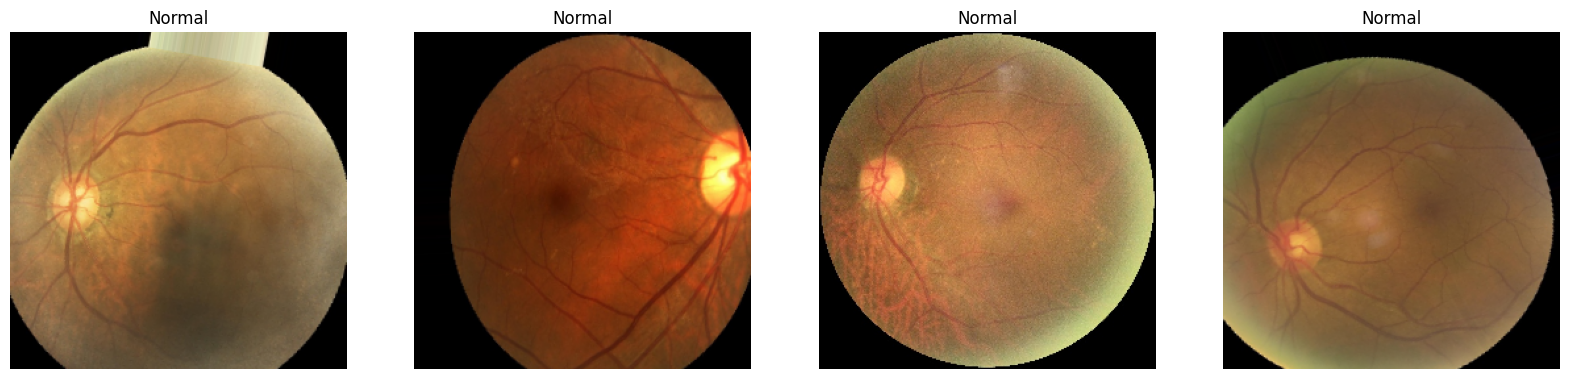

In [15]:
# Get the next batch of images from the training generator
images, labels = next(balanced_generator)
class_labels = ['Normal', 'Diabetes', 'Glaucoma', 'Cataract', 'AMD', 'Hypertension', 'Myopia', 'Other diseases']

# Plot the images and labels using the show_batch function
def show_batch(images, labels, ncols=4):
    figure, axs = plt.subplots(1, ncols, figsize=(20, 20))
    for i in range(ncols):
        axs[i].imshow(images[i].astype('uint8'))
        axs[i].set_title(class_labels[np.argmax(labels[i])])
        axs[i].axis('off')
        
show_batch(images, labels, ncols=4)

In [18]:
# Add the 'label_encoded' column to X_train by matching indices with y_train_final
X_test['label_encoded'] = y_test.values

# Now, ensure the directory path in 'flow_from_dataframe' matches the file structure and the 'filename' column contains the correct filenames.
test_generator = no_augmentation.flow_from_dataframe(
    dataframe=X_test,
    directory='dataset/preprocessed_images',  # Update this as per your directory structure
    x_col='filename',
    y_col='label_encoded',
    target_size=(256, 256),
    color_mode='rgb',
    class_mode='raw',
    batch_size=16,
    shuffle=False
)

# Repeat for the validation generator
X_val['label_encoded'] = y_val.values  # Ensure y_val is aligned with X_val

val_generator = no_augmentation.flow_from_dataframe(
    dataframe=X_val,
    directory='dataset/preprocessed_images',  # Update this as per your directory structure
    x_col='filename',
    y_col='label_encoded',
    target_size=(256, 256),
    color_mode='rgb',
    class_mode='raw',
    batch_size=16,
    shuffle=False
)

Found 1279 validated image filenames.
Found 1023 validated image filenames.


In [19]:
X_train, y_train = next(balanced_generator)
X_test, y_test = next(test_generator)
X_val, y_val = next(val_generator)

In [ ]:
from sklearn.linear_model import LogisticRegression

# Initialize the logistic regression model
lr = LogisticRegression( max_iter=1000, random_state=42)
# Reshape the input data to have 2 dimensions
X_train_2d = X_train.reshape(X_train.shape[0], -1)
X_test_2d = X_test.reshape(X_test.shape[0], -1)

# Fit the model with the reshaped data
lr.fit(X_train_2d, np.argmax(y_train, axis=1))

# Check the score on the test set
score = lr.score(X_test_2d, np.argmax(y_test, axis=1))
print("Test Score:", score)

In [51]:
from sklearn.svm import SVC
svm = SVC()
svm.fit(X_train_2d, np.argmax(y_train, axis=1))
svm.score(X_test_2d, np.argmax(y_test, axis=1))

0.5

In [52]:
from sklearn.ensemble import RandomForestClassifier
rf = RandomForestClassifier(n_estimators=40)
rf.fit(X_train_2d, np.argmax(y_train, axis=1))
rf.score(X_test_2d, np.argmax(y_test, axis=1))

0.46875

# Training the model

- A BatchNormalization layer and a Dropout layer are added immediately after flattening the output of the pretrained ResNet50 base. A Dense layer with both L1 and L2 regularization follows the Dropout layer. The regularization helps prevent overfitting by adding a penalty for larger weights, and Dropout randomly sets input units to 0 with a frequency of rate at each step during training time, which helps prevent overfitting. Batch Normalization normalizes the inputs heading into the next layer, which ensures that the network always creates activations with the same distribution that we desire.

Calculating Class Weights 

In [25]:
import numpy as np
from sklearn.utils.class_weight import compute_class_weight


# The labels are already in the format compute_class_weight expects
class_weights = compute_class_weight(
    class_weight='balanced',
    classes=np.unique(y_train_final),
    y=y_train_final

)

# Create a dictionary to map the class indices to their respective weights
class_weights_dict = {i: weight for i, weight in enumerate(class_weights)}

# Display the class weights
print(class_weights_dict)

{0: 2.9382183908045976, 1: 2.6907894736842106, 2: 0.4939613526570048, 3: 2.7194148936170213, 4: 6.4715189873417724, 5: 3.477891156462585, 6: 0.28183572216097025, 7: 1.1042116630669547}


# Early Stopping 
- This is implemented to prevent overfitting if the validation loss begins to rise consisenly as training goes on. 

In [26]:
# Setup callbacks
checkpoint = ModelCheckpoint(filepath='best_model_Resnet50.h5', verbose=1, save_best_only=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=3, min_lr=1e-7, verbose=1) # increased patience from 3 to 5 and factor from 0.2 to 0.5
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True) # increased from 5 to 10


callbacks = [early_stopping, checkpoint, reduce_lr]


In [27]:
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from tensorflow.keras.applications import ResNet50
from tensorflow.keras import layers

In [29]:
base_model = ResNet50(
    include_top=False,
    weights='imagenet',
    input_shape=(224, 224, 3)
    )

for layer in base_model.layers:
    layer.trainable = False # Freeze the layers
    

# Create the custom layers to append to ResNet50
x = base_model.output
x = Conv2D(filters=64, kernel_size=(3,3), activation='relu', padding = 'same')(x)
x = MaxPooling2D(pool_size=(2,2))(x)
x = Conv2D(filters=128, kernel_size=(3,3), activation='relu',padding = 'same')(x)
x = MaxPooling2D(pool_size=(2,2))(x)
x = Dropout(0.5)(x)
x = Flatten()(x)
x = Dense(256, activation='relu', kernel_regularizer=l2(0.001))(x)
x = Dense(128, activation='relu')(x)
x = Dropout(0.5)(x)
x = Dense(64, activation='relu')(x)
predictions = Dense(8, activation='softmax')(x) 

resnet_50_model = Model(inputs=base_model.input, outputs=predictions)

resnet_50_model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])


In [30]:
resnet_50_model.summary()

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv1_pad (ZeroPadding2D)      (None, 230, 230, 3)  0           ['input_2[0][0]']                
                                                                                                  
 conv1_conv (Conv2D)            (None, 112, 112, 64  9472        ['conv1_pad[0][0]']              
                                )                                                                 
                                                                                            

In [33]:
# Modify the output layer to have 8 units for 8 classes
predictions = Dense(8, activation='softmax')(x) 

# Compile the model again
resnet_50_model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Fit the model with callbacks
history = resnet_50_model.fit(
    balanced_generator,
    steps_per_epoch=100,
    epochs=10,
    validation_data=val_generator,
    validation_steps=10,
    class_weight=class_weights_dict,
    callbacks=callbacks
)

Epoch 1/10


ValueError: in user code:

    File "c:\Users\duwak\.conda\envs\TF\lib\site-packages\keras\engine\training.py", line 1051, in train_function  *
        return step_function(self, iterator)
    File "c:\Users\duwak\.conda\envs\TF\lib\site-packages\keras\engine\training.py", line 1040, in step_function  **
        outputs = model.distribute_strategy.run(run_step, args=(data,))
    File "c:\Users\duwak\.conda\envs\TF\lib\site-packages\keras\engine\training.py", line 1030, in run_step  **
        outputs = model.train_step(data)
    File "c:\Users\duwak\.conda\envs\TF\lib\site-packages\keras\engine\training.py", line 890, in train_step
        loss = self.compute_loss(x, y, y_pred, sample_weight)
    File "c:\Users\duwak\.conda\envs\TF\lib\site-packages\keras\engine\training.py", line 948, in compute_loss
        return self.compiled_loss(
    File "c:\Users\duwak\.conda\envs\TF\lib\site-packages\keras\engine\compile_utils.py", line 201, in __call__
        loss_value = loss_obj(y_t, y_p, sample_weight=sw)
    File "c:\Users\duwak\.conda\envs\TF\lib\site-packages\keras\losses.py", line 139, in __call__
        losses = call_fn(y_true, y_pred)
    File "c:\Users\duwak\.conda\envs\TF\lib\site-packages\keras\losses.py", line 243, in call  **
        return ag_fn(y_true, y_pred, **self._fn_kwargs)
    File "c:\Users\duwak\.conda\envs\TF\lib\site-packages\keras\losses.py", line 1787, in categorical_crossentropy
        return backend.categorical_crossentropy(
    File "c:\Users\duwak\.conda\envs\TF\lib\site-packages\keras\backend.py", line 5119, in categorical_crossentropy
        target.shape.assert_is_compatible_with(output.shape)

    ValueError: Shapes (None, 1) and (None, 8) are incompatible


Finetuning

In [67]:
for layer in base_model.layers[-10:]:
    layer.trainable = True
    
resnet_50_model.compile(optimizer=Adam(lr=1e-5), loss='categorical_crossentropy', metrics=['accuracy'])

c:\Users\duwak\.conda\envs\TF\lib\site-packages\keras\optimizers\optimizer_v2\adam.py:110: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


In [68]:
# Fit the model with callbacks
history = resnet_50_model.fit(
    train_generator,
    validation_data=validation_generator,
    epochs=50,
    callbacks=callbacks,
    class_weight=class_weights_dict
)

Epoch 1/50
474/474 [==============================] - ETA: 0s - loss: 1.0443 - accuracy: 0.6096
Epoch 1: val_loss did not improve from 1.27398
474/474 [==============================] - 72s 145ms/step - loss: 1.0443 - accuracy: 0.6096 - val_loss: 1.3642 - val_accuracy: 0.5327 - lr: 1.0000e-05
Epoch 2/50
474/474 [==============================] - ETA: 0s - loss: 0.9649 - accuracy: 0.6384
Epoch 2: val_loss did not improve from 1.27398
474/474 [==============================] - 68s 143ms/step - loss: 0.9649 - accuracy: 0.6384 - val_loss: 1.3628 - val_accuracy: 0.5386 - lr: 1.0000e-05
Epoch 3/50
474/474 [==============================] - ETA: 0s - loss: 0.9152 - accuracy: 0.6574
Epoch 3: val_loss did not improve from 1.27398
474/474 [==============================] - 68s 144ms/step - loss: 0.9152 - accuracy: 0.6574 - val_loss: 1.3683 - val_accuracy: 0.5406 - lr: 1.0000e-05
Epoch 4/50
474/474 [==============================] - ETA: 0s - loss: 0.8677 - accuracy: 0.6715
Epoch 4: val_loss did 

# Evaluating Model 

Model Accuracy Graph Analysis

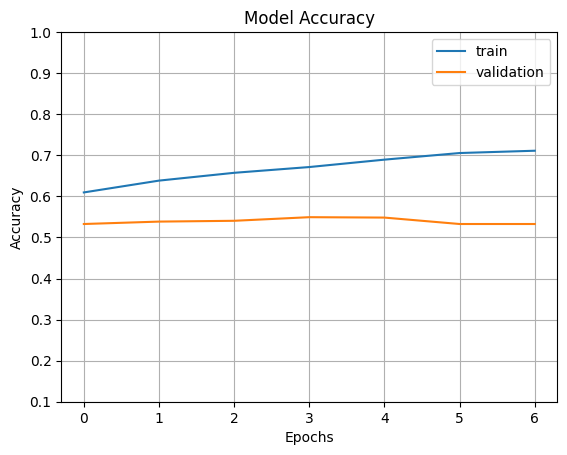

In [69]:
fig1 = plt.gcf()
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.axis(ymin=0.1,ymax=1)
plt.grid()
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epochs')
plt.legend(['train', 'validation'])
plt.show()

Model Loss Graph Analysis 

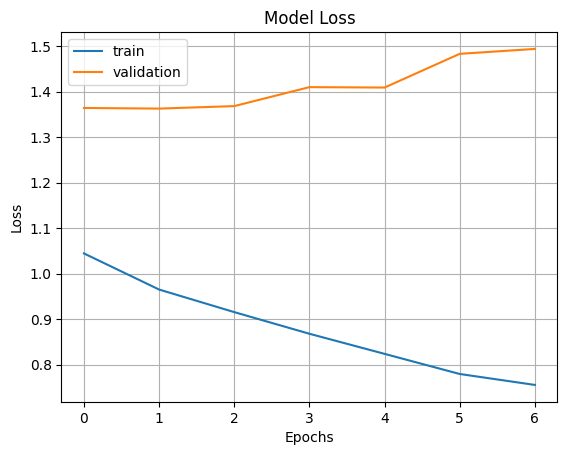

In [70]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.grid()
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epochs')
plt.legend(['train', 'validation'])
plt.show()

# Making Predictions

In [71]:
model_best = keras.models.load_model('best_model_Resnet50.h5')

# Evaluate the model on the test set
test_loss, test_acc = model_best.evaluate(test_generator, verbose=1)
print(f"Test accuracy: {test_acc:.4f}")

# Get the predictions for the test set

predictions = model_best.predict(test_generator, verbose=1)

# Get the predicted classes
predicted_classes = np.argmax(predictions, axis=1)

# Get the true classes
true_classes = test_generator.classes

# Get the class labels
class_labels = list(test_generator.class_indices.keys())

40/40 [==============================] - 6s 122ms/step - loss: 1.3144 - accuracy: 0.5121
Test accuracy: 0.5121
40/40 [==============================] - 5s 119ms/step


In [72]:
# Assuming these were stored from the original generator before wrapping
test_samples = test_generator.samples
test_batch_size = test_generator.batch_size

# Calculate the correct number of steps to cover all the samples
steps = np.ceil(test_samples / test_batch_size)

# Evaluate the model on the test dataset
resnet_50_model.evaluate(test_generator, steps=steps)

# Re-generate predictions with the corrected steps
predictions = resnet_50_model.predict(test_generator, steps=steps)

# Get the predicted classes again
predicted_classes = np.argmax(predictions, axis=1)


40/40 [==============================] - 5s 120ms/step


# Predictions Result Evaluation

In [73]:
from sklearn.metrics import classification_report, balanced_accuracy_score, roc_auc_score

Classification Report 

In [74]:

class_labels = ['Normal', 'Diabetes', 'Glaucoma', 'Cataract', 'AMD', 'Hypertension', 'Myopia', 'Other diseases']

# Get the true classes from the DataFrame
true_classes = test_generator.classes

# Now, the number of predicted classes should match the number of true classes
# Generate the classification report again
report = classification_report(true_classes, predicted_classes, target_names=class_labels, zero_division=0)

print(report)


                precision    recall  f1-score   support

        Normal       0.05      0.02      0.03        46
      Diabetes       0.68      0.74      0.71        58
      Glaucoma       0.46      0.07      0.12       333
      Cataract       0.45      0.34      0.39        61
           AMD       0.13      0.11      0.12        28
  Hypertension       0.79      0.88      0.83        48
        Myopia       0.50      0.90      0.64       569
Other diseases       0.00      0.00      0.00       136

      accuracy                           0.50      1279
     macro avg       0.38      0.38      0.36      1279
  weighted avg       0.43      0.50      0.40      1279



Balanced Accuracy Score 

In [75]:
balanced_accuracy = balanced_accuracy_score(true_classes, predicted_classes)
print('Balanced Accuracy: {:.4f}'.format(balanced_accuracy))

Balanced Accuracy: 0.3825


Area Under the Reciever Operating Characteristic Curve (AUC-ROC)

In [76]:
from keras.utils import to_categorical
true_classes_one_hot = to_categorical(true_classes, num_classes=8)

# Calculate ROC AUC for multi-class classification
roc_auc = roc_auc_score(true_classes_one_hot, predictions, average='macro', multi_class='ovo')

print(f'ROC AUC: {roc_auc:.4f}')

ROC AUC: 0.7437


Confusion Matrix 

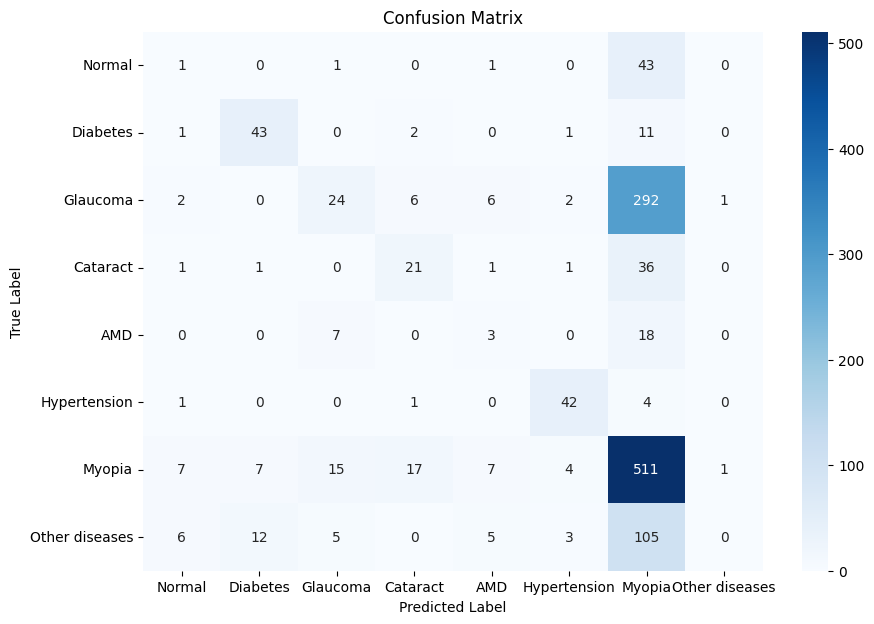

In [77]:
import seaborn as sns
from sklearn.metrics import confusion_matrix

# Calculate confusion matrix
cm = confusion_matrix(true_classes, predicted_classes)

# Plot confusion matrix
plt.figure(figsize=(10,7))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_labels, yticklabels=class_labels)
plt.title('Confusion Matrix')
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.show()

# Prediction Evaluation

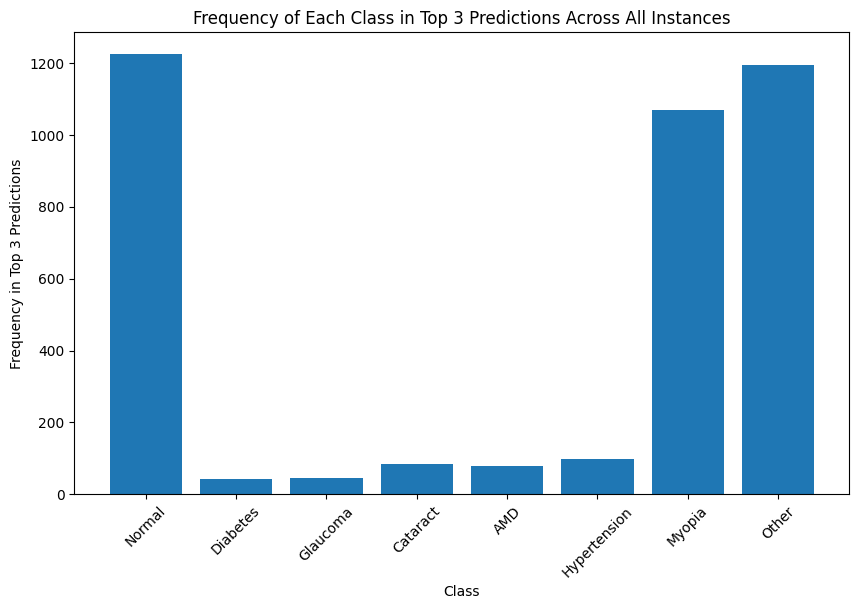

In [50]:
class_labels = ['Normal', 'Diabetes', 'Glaucoma', 'Cataract', 'AMD', 'Hypertension', 'Myopia', 'Other']

# Function to get top 3 indices for all predictions
def get_top3_indices(predictions):
    return predictions.argsort()[:, -3:]

# Count the frequency of each class being in the top 3
top3_indices = get_top3_indices(predictions)
class_counts = np.zeros(len(class_labels))

for indices in top3_indices:
    for index in indices:
        class_counts[index] += 1



# Plotting
plt.figure(figsize=(10, 6))
plt.bar(class_labels, class_counts)
plt.xlabel('Class')
plt.ylabel('Frequency in Top 3 Predictions')
plt.title('Frequency of Each Class in Top 3 Predictions Across All Instances')
plt.xticks(rotation=45)
plt.show()

In [51]:
# Save the model
resnet_50_model.save('resnet_50_model_v2.h5')